### Blackjack game setting up using openai gym

In [100]:
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from gym import wrappers
env = gym.make('Blackjack-v0')

In [104]:
import math
import numpy as np
from collections import namedtuple
from itertools import count
# pytorch stuff
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# some global variables for deep q learning
BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
steps_done = 0


In [101]:
def get_payout_results(num_rounds, num_samples, action_method):
    average_payouts = []
    for sample in range(num_samples):
        current_round = 1
        total_payout = 0  # to store total payout over 'num_rounds'
        
        while current_round <= num_rounds:
            action = action_method()  # take random action 
            obs, payout, is_done, _ = env.step(action)
            total_payout += payout
            if is_done:
                env.reset()  # Environment deals new cards to player and dealer
                current_round += 1
        average_payouts.append(total_payout)
        
    plt.plot(average_payouts)
    plt.xlabel('num_samples')
    plt.ylabel('payout after 1000 rounds')
    plt.show()
    print("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts) / num_samples))


#### The payout given by random pick

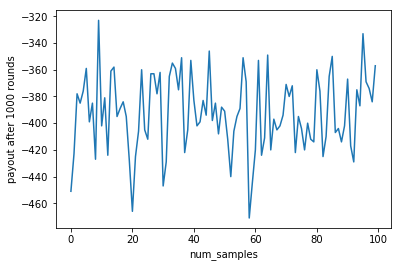

Average payout after 1000 rounds is -392.49


In [102]:
num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples
get_payout_results(num_rounds, num_samples, env.action_space.sample)

#### The payout given by some optimal strategy (rule base)

In [96]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Actions obtained from figure 11 here- https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*8 # 2 to 9
    actions.append([1]*4 + [0]*2 + [1]*4) #10
    actions.append([1] + [0]*6 + [1]*3) #11
    actions.append([0] + [1]*9) #12
    actions.append([0]*2 + [1]*8) #13
    actions.append([0]*1 + [1]*9) #14
    actions.append([0]*2 + [1]*8) #15
    actions.append([0]*5 + [1]*5) #16
    actions.append([0]*4 + [1]*6) #17
    actions.extend([[0]*10]*4) # 18 to 21
    
    # dealer_up_card-2 takes care of input 1 which correcly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

Average payout after 1000 rounds is -96.81


In [103]:
# Make sure actions have been stored correctly mainly when dealer's upcard is A
assert (normal_strategy(15, 2)) == 0
assert (normal_strategy(15, 1)) == 1

total_payout = 0 # to store total payout over 'num_rounds'

for _ in range(num_samples):
    round = 1
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        
        # Take action based on normal strategy stored above
        action = normal_strategy(player_sum, dealer_up_card) 
        
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))

Average payout after 1000 rounds is -100.48


#### The payout given by basic reinforcement learning method (q_learning etc)

In [20]:
class Agent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=30000):
        self.env = env
        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))
        # Set parameters of the learning agent
        self.Q = dict()          # Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future

        # epsilon will reduce linearly until it reaches 0 based on num_episodes_to_train
        # epsilon drops to 90% of its inital value in the first 30% of num_episodes_to_train
        # epsilon then drops to 10% of its initial value in the next 40% of num_episodes_to_train
        # epsilon finally becomes 0 in the final 30% of num_episodes_to_train
        self.num_episodes_to_train = num_episodes_to_train # Change epsilon each episode based on this
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train) # reduces epilon faster
        self.num_episodes_to_train_left = num_episodes_to_train

    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)
        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)
            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)
        self.update_parameters()
        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives an award.
        This function does not consider future rewards
        when conducting learning.
        """
        # Q = Q*(1-alpha) + alpha(reward + discount * utility of next observation)
        # Q = Q - Q * alpha + alpha(reward + discount * self.get_maxQ(next_observation))
        # Q = Q - alpha (-Q + reward + discount * self.get_maxQ(next_observation))
        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

In [89]:
agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=1800)

Average payout after 1000 rounds after training for 200 episodes is -206.28
Average payout after 1000 rounds after training for 400 episodes is -167.72
Average payout after 1000 rounds after training for 600 episodes is -244.29
Average payout after 1000 rounds after training for 800 episodes is -182.1
Average payout after 1000 rounds after training for 1000 episodes is -159.37
Average payout after 1000 rounds after training for 1200 episodes is -172.95


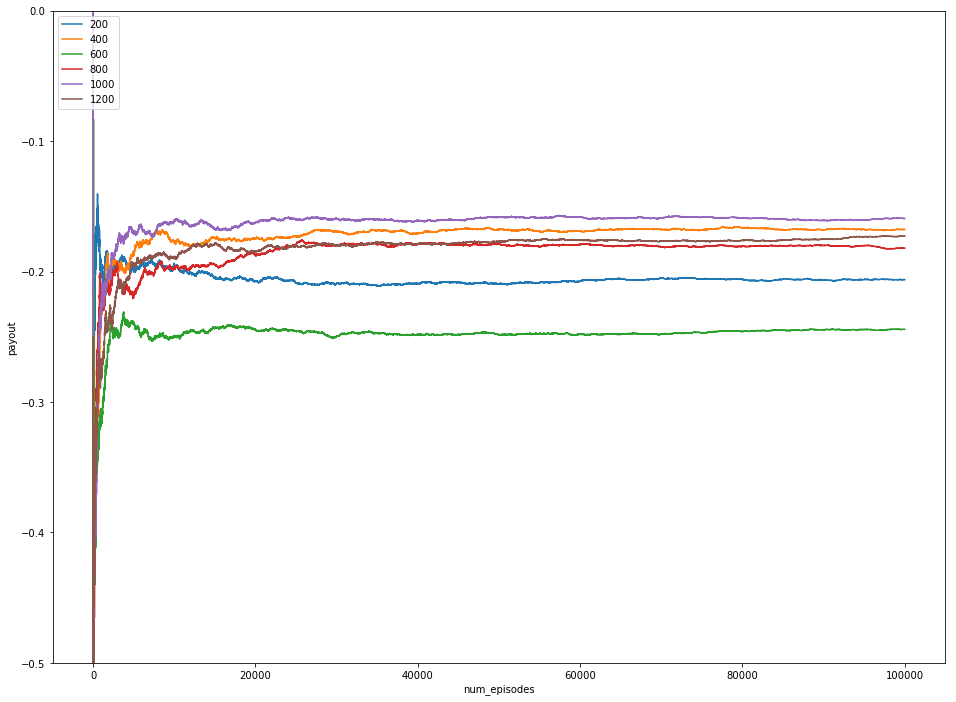

In [133]:
from gym import wrappers
env = gym.make('Blackjack-v0')
num_episodes_values = range(200, 1400, 200)

plt.figure(num=None, figsize=(16, 12))
plt.clf()
                          
# Run simulations over different values of 'num_episodes_to_train' to find the one with best payout
for num_episodes_value in num_episodes_values:
    total_payout = 0 # to store total payout over 'num_rounds'
    average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
    agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=num_episodes_value)

    observation = env.reset()
    for sample in range(num_samples):
        round = 1
        # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
        while round <= num_rounds:
            action = agent.choose_action(observation)
            next_observation, payout, is_done, _ = env.step(action)
            agent.learn(observation, action, payout, next_observation)
            total_payout += payout
            observation = next_observation
            if is_done:
                observation = env.reset() # Environment deals new cards to player and dealer
                round += 1
                average_payouts.append(total_payout/(sample*num_rounds + round))

    plt.plot(average_payouts)
    print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/(num_samples)))
    

# Plot payout per 1000 episodes for each value of 'num_episodes_to_train' in the same graph
plt.xlabel('num_episodes')
plt.ylabel('payout')
plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.ylim(-0.5,0) # To zoom into this region
plt.show()
env.close()

#### The payout given by basic reinforcement learning method (q_learning etc) with some memory simulation

### Deep Q learning

#### TODO: Transfer the model input into vector format

In [7]:
def transfer_card_input(player, dealer):
    # transfer the dealer and player card into a fixed dimension list
    deal_card = [dealer[0]]
    player_card = player + [0] * (15 - len(player))
    return player_card + deal_card

In [8]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """Saves a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None) # grow the memory
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1)%self.capacity # loop around
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [9]:
class NetworkAgent(nn.Module):
    
    def __init__(self, n_inputs, n_outputs, gamma):
        self.H = 128 # the number of hidden units (you can change this or make it a parameter)
        self.MEM_SIZE = 10000 # could be made a parmaeter
        self.BATCH_SIZE = 64
        nn.Module.__init__(self)
        self.num_inputs = n_inputs
        self.num_actions = n_outputs
        self.l1 = nn.Linear(self.num_inputs, self.H) # defines the input units and layer 1 weights
        self.l2 = nn.Linear(self.H, 10) # defines the output units (actions) and layer 2 weights
        self.l3 = nn.Linear(10, self.num_actions)
        self.memory = ReplayMemory(self.MEM_SIZE) # create a replay memory 
        self.gamma = gamma
    
    # makes forward predictions from the current state, x, to the actions
    def forward(self, x):
        # the forward function is required by the neural network and takes an input
        # vector (x) representing in this case the current state and makes a prediction
        # about the activation of the output units in the network.
        x = F.relu(self.l1(x)) # state -> hidden -> relu()
        x = F.relu(self.l2(x)) # hidden -> hidden
        x = F.softmax(self.l3(x))
        return x 
    
    def choose(self, state):
        global steps_done
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                        math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        if sample > eps_threshold:
            state_vec = Variable(FloatTensor([state]), volatile=True).type(FloatTensor)
            action = self(state_vec).max(1)[1].data.numpy()[0]
            return action
        else:
            return random.randrange(2)
        
    # stores the last state, action pair in a format that is useful to the network
    def remember(self, *args):
        args = (FloatTensor([args[0]]),
               args[1],
               FloatTensor([args[2]]),
               FloatTensor([args[3]]))
        self.memory.push(*args)
    
    def learn(self):
        if len(self.memory) < self.BATCH_SIZE:
            return # don't do learning if you haven't accumulated enough experience yet (this could be improved)
        # get a bunch of training data
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
    
        # convert to variables (necessary for batch training)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.from_numpy(np.array(batch_action)).view(self.BATCH_SIZE, -1))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_reward = Variable(torch.cat(batch_reward))
        # steps to be implemented:
        # 1. compute current Q values for all actions
        state_action_values = self(batch_state).gather(1, batch_action)
        
        # 2. compute exected Q values estimated from action which given max Q values (on-policy)
        next_state_values = self(batch_next_state).max(1)[0]
        expected_state_action_values = (next_state_values * self.gamma) + batch_reward

        # 3. compute the loss/error function (one suggestion is F.smooth_l1_loss())
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        
        # 4. apply the error and backprop the gradients
        optimizer.zero_grad()
        loss.backward()
        for param in DQ_agent.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

In [60]:
total_payout = 0 # to store total payout over 'num_rounds' 
DQ_agent = NetworkAgent(n_inputs=16, n_outputs=2, gamma=0.75)
optimizer = optim.RMSprop(DQ_agent.parameters(), lr = 0.0006)
env.reset()

  1%|          | 1/100 [00:04<07:31,  4.56s/it]

payout for this epoch is -155.0


  2%|▏         | 2/100 [00:08<07:17,  4.47s/it]

payout for this epoch is -179.0


  3%|▎         | 3/100 [00:14<07:57,  4.93s/it]

payout for this epoch is -133.0


  4%|▍         | 4/100 [00:19<07:51,  4.92s/it]

payout for this epoch is -171.0


  5%|▌         | 5/100 [00:24<07:39,  4.84s/it]

payout for this epoch is -102.0


  6%|▌         | 6/100 [00:28<07:27,  4.76s/it]

payout for this epoch is -58.0


  7%|▋         | 7/100 [00:33<07:28,  4.82s/it]

payout for this epoch is -195.0


  8%|▊         | 8/100 [00:38<07:27,  4.86s/it]

payout for this epoch is -174.0


  9%|▉         | 9/100 [00:43<07:25,  4.90s/it]

payout for this epoch is -185.0


 10%|█         | 10/100 [00:48<07:25,  4.94s/it]

payout for this epoch is -190.0


 11%|█         | 11/100 [00:53<07:23,  4.98s/it]

payout for this epoch is -117.0


 12%|█▏        | 12/100 [00:58<07:16,  4.97s/it]

payout for this epoch is -165.0


 13%|█▎        | 13/100 [01:03<07:05,  4.89s/it]

payout for this epoch is -133.0


 14%|█▍        | 14/100 [01:08<07:05,  4.95s/it]

payout for this epoch is -149.0


 15%|█▌        | 15/100 [01:13<06:54,  4.87s/it]

payout for this epoch is -191.0


 16%|█▌        | 16/100 [01:18<06:51,  4.90s/it]

payout for this epoch is -179.0


 17%|█▋        | 17/100 [01:22<06:37,  4.79s/it]

payout for this epoch is -187.0


 18%|█▊        | 18/100 [01:27<06:31,  4.77s/it]

payout for this epoch is -146.0


 19%|█▉        | 19/100 [01:32<06:29,  4.81s/it]

payout for this epoch is -143.0


 20%|██        | 20/100 [01:37<06:25,  4.81s/it]

payout for this epoch is -163.0


 21%|██        | 21/100 [01:42<06:20,  4.82s/it]

payout for this epoch is -141.0


 22%|██▏       | 22/100 [01:46<06:14,  4.80s/it]

payout for this epoch is -95.0


 23%|██▎       | 23/100 [01:51<06:03,  4.72s/it]

payout for this epoch is -160.0


 24%|██▍       | 24/100 [01:55<05:49,  4.60s/it]

payout for this epoch is -210.0


 25%|██▌       | 25/100 [02:00<05:42,  4.57s/it]

payout for this epoch is -103.0


 26%|██▌       | 26/100 [02:04<05:36,  4.55s/it]

payout for this epoch is -176.0


 27%|██▋       | 27/100 [02:09<05:38,  4.64s/it]

payout for this epoch is -127.0


 28%|██▊       | 28/100 [02:14<05:40,  4.74s/it]

payout for this epoch is -49.0


 29%|██▉       | 29/100 [02:19<05:39,  4.78s/it]

payout for this epoch is -101.0


 30%|███       | 30/100 [02:25<05:54,  5.06s/it]

payout for this epoch is -123.0


 31%|███       | 31/100 [02:30<05:48,  5.04s/it]

payout for this epoch is -118.0


 32%|███▏      | 32/100 [02:35<05:47,  5.10s/it]

payout for this epoch is -164.0


 33%|███▎      | 33/100 [02:41<05:56,  5.32s/it]

payout for this epoch is -136.0


 34%|███▍      | 34/100 [02:46<05:43,  5.21s/it]

payout for this epoch is -139.0


 35%|███▌      | 35/100 [02:51<05:32,  5.11s/it]

payout for this epoch is -176.0


 36%|███▌      | 36/100 [02:57<05:52,  5.51s/it]

payout for this epoch is -113.0


 37%|███▋      | 37/100 [03:03<05:56,  5.67s/it]

payout for this epoch is -94.0


 38%|███▊      | 38/100 [03:08<05:36,  5.43s/it]

payout for this epoch is -125.0


 39%|███▉      | 39/100 [03:12<05:14,  5.16s/it]

payout for this epoch is -163.0


 40%|████      | 40/100 [03:17<04:59,  4.99s/it]

payout for this epoch is -169.0


 41%|████      | 41/100 [03:22<04:51,  4.94s/it]

payout for this epoch is -77.0


 42%|████▏     | 42/100 [03:27<04:42,  4.87s/it]

payout for this epoch is -163.0


 43%|████▎     | 43/100 [03:31<04:28,  4.71s/it]

payout for this epoch is -71.0


 44%|████▍     | 44/100 [03:35<04:14,  4.54s/it]

payout for this epoch is -127.0


 45%|████▌     | 45/100 [03:40<04:16,  4.66s/it]

payout for this epoch is -128.0


 46%|████▌     | 46/100 [03:45<04:12,  4.67s/it]

payout for this epoch is -64.0


 47%|████▋     | 47/100 [03:50<04:12,  4.77s/it]

payout for this epoch is -93.0


 48%|████▊     | 48/100 [03:55<04:11,  4.85s/it]

payout for this epoch is -119.0


 49%|████▉     | 49/100 [04:00<04:14,  4.99s/it]

payout for this epoch is -119.0


 50%|█████     | 50/100 [04:05<04:10,  5.02s/it]

payout for this epoch is -102.0


 51%|█████     | 51/100 [04:10<04:03,  4.97s/it]

payout for this epoch is -92.0


 52%|█████▏    | 52/100 [04:16<04:18,  5.39s/it]

payout for this epoch is -95.0


 53%|█████▎    | 53/100 [04:21<04:08,  5.28s/it]

payout for this epoch is -159.0


 54%|█████▍    | 54/100 [04:27<04:03,  5.30s/it]

payout for this epoch is -227.0


 55%|█████▌    | 55/100 [04:33<04:17,  5.71s/it]

payout for this epoch is -125.0


 56%|█████▌    | 56/100 [04:38<03:59,  5.43s/it]

payout for this epoch is -117.0


 57%|█████▋    | 57/100 [04:44<03:58,  5.54s/it]

payout for this epoch is -147.0


 58%|█████▊    | 58/100 [04:49<03:45,  5.36s/it]

payout for this epoch is -91.0


 59%|█████▉    | 59/100 [04:55<03:50,  5.63s/it]

payout for this epoch is -87.0


 60%|██████    | 60/100 [05:01<03:49,  5.73s/it]

payout for this epoch is -56.0


 61%|██████    | 61/100 [05:06<03:30,  5.41s/it]

payout for this epoch is -171.0


 62%|██████▏   | 62/100 [05:10<03:15,  5.14s/it]

payout for this epoch is -131.0


 63%|██████▎   | 63/100 [05:15<03:03,  4.97s/it]

payout for this epoch is -124.0


 64%|██████▍   | 64/100 [05:19<02:53,  4.82s/it]

payout for this epoch is -177.0


 65%|██████▌   | 65/100 [05:24<02:43,  4.67s/it]

payout for this epoch is -104.0


 66%|██████▌   | 66/100 [05:28<02:38,  4.66s/it]

payout for this epoch is -139.0


 67%|██████▋   | 67/100 [05:34<02:44,  4.99s/it]

payout for this epoch is -94.0


 68%|██████▊   | 68/100 [05:39<02:42,  5.07s/it]

payout for this epoch is -144.0


 69%|██████▉   | 69/100 [05:44<02:36,  5.05s/it]

payout for this epoch is -158.0


 70%|███████   | 70/100 [05:49<02:27,  4.92s/it]

payout for this epoch is -162.0


 71%|███████   | 71/100 [05:53<02:17,  4.73s/it]

payout for this epoch is -143.0


 72%|███████▏  | 72/100 [05:58<02:08,  4.60s/it]

payout for this epoch is -172.0


 73%|███████▎  | 73/100 [06:02<02:03,  4.58s/it]

payout for this epoch is -142.0


 74%|███████▍  | 74/100 [06:06<01:56,  4.49s/it]

payout for this epoch is -88.0


 75%|███████▌  | 75/100 [06:11<01:53,  4.53s/it]

payout for this epoch is -117.0


 76%|███████▌  | 76/100 [06:16<01:49,  4.56s/it]

payout for this epoch is -132.0


 77%|███████▋  | 77/100 [06:20<01:45,  4.58s/it]

payout for this epoch is -181.0


 78%|███████▊  | 78/100 [06:25<01:41,  4.62s/it]

payout for this epoch is -138.0


 79%|███████▉  | 79/100 [06:30<01:37,  4.63s/it]

payout for this epoch is -198.0


 80%|████████  | 80/100 [06:34<01:34,  4.71s/it]

payout for this epoch is -102.0


 81%|████████  | 81/100 [06:40<01:35,  5.05s/it]

payout for this epoch is -119.0


 82%|████████▏ | 82/100 [06:46<01:33,  5.17s/it]

payout for this epoch is -139.0


 83%|████████▎ | 83/100 [06:51<01:26,  5.07s/it]

payout for this epoch is -147.0


 84%|████████▍ | 84/100 [06:55<01:18,  4.91s/it]

payout for this epoch is -193.0


 85%|████████▌ | 85/100 [07:00<01:13,  4.87s/it]

payout for this epoch is -189.0


 86%|████████▌ | 86/100 [07:05<01:07,  4.79s/it]

payout for this epoch is -84.0


 87%|████████▋ | 87/100 [07:09<01:00,  4.67s/it]

payout for this epoch is -123.0


 88%|████████▊ | 88/100 [07:14<00:55,  4.66s/it]

payout for this epoch is -136.0


 89%|████████▉ | 89/100 [07:18<00:50,  4.63s/it]

payout for this epoch is -180.0


 90%|█████████ | 90/100 [07:23<00:46,  4.65s/it]

payout for this epoch is -85.0


 91%|█████████ | 91/100 [07:27<00:40,  4.51s/it]

payout for this epoch is -151.0


 92%|█████████▏| 92/100 [07:31<00:35,  4.44s/it]

payout for this epoch is -133.0


 93%|█████████▎| 93/100 [07:36<00:31,  4.43s/it]

payout for this epoch is -178.0


 94%|█████████▍| 94/100 [07:40<00:26,  4.45s/it]

payout for this epoch is -139.0


 95%|█████████▌| 95/100 [07:45<00:22,  4.48s/it]

payout for this epoch is -199.0


 96%|█████████▌| 96/100 [07:49<00:17,  4.48s/it]

payout for this epoch is -81.0


 97%|█████████▋| 97/100 [07:54<00:13,  4.42s/it]

payout for this epoch is -181.0


 98%|█████████▊| 98/100 [07:58<00:08,  4.38s/it]

payout for this epoch is -94.0


 99%|█████████▉| 99/100 [08:02<00:04,  4.35s/it]

payout for this epoch is -149.0


100%|██████████| 100/100 [08:06<00:00,  4.30s/it]

payout for this epoch is -202.0
Average payout after 99 epoch after training is -137.75


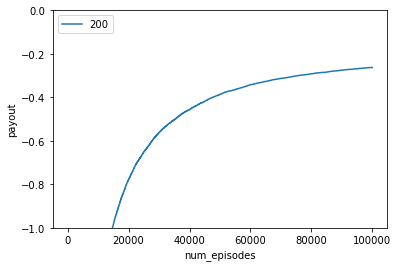

In [73]:
average_payouts = []
round_payouts = []
for epoch in tqdm(range(num_samples)):
    current_round = 1
    round_payout = 0
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while current_round <= num_rounds:
        state = transfer_card_input(env.player, env.dealer)
        # observation = transfer_card_input(env.player, env.dealer) 
        action = DQ_agent.choose(state)
        # action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        next_state = transfer_card_input(env.player, env.dealer)
        DQ_agent.remember(state, action, next_state, payout)
        if is_done:
            total_payout += payout
            round_payout += payout
            env.reset() # Environment deals new cards to player and dealer
            current_round += 1
            DQ_agent.learn()
            average_payouts.append(total_payout/(epoch*num_rounds + current_round))
    round_payouts.append(round_payout)
    print("payout for this epoch is {}".format(round_payout))
    # Apply early stop during training
    if round_payout > -30:
        break

plt.plot(average_payouts)
print ("Average payout after {} epoch after training is {}".format(epoch, sum(round_payouts)/ num_samples))


# Plot payout per 1000 episodes for each value of 'num_episodes_to_train' in the same graph
plt.xlabel('num_episodes')
plt.ylabel('payout')
plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.ylim(-1,0) # To zoom into this region
plt.show()
env.close()

  1%|          | 1/100 [00:00<00:54,  1.83it/s]

payout for this epoch is -63.0


  2%|▏         | 2/100 [00:01<00:52,  1.88it/s]

payout for this epoch is -89.0


  3%|▎         | 3/100 [00:01<00:51,  1.89it/s]

payout for this epoch is -143.0


  4%|▍         | 4/100 [00:02<00:50,  1.92it/s]

payout for this epoch is -139.0


  5%|▌         | 5/100 [00:02<00:48,  1.95it/s]

payout for this epoch is -125.0


  6%|▌         | 6/100 [00:03<00:47,  1.98it/s]

payout for this epoch is -121.0


  7%|▋         | 7/100 [00:03<00:46,  1.99it/s]

payout for this epoch is -95.0


  8%|▊         | 8/100 [00:04<00:46,  1.99it/s]

payout for this epoch is -90.0


  9%|▉         | 9/100 [00:04<00:46,  1.96it/s]

payout for this epoch is -110.0


 10%|█         | 10/100 [00:05<00:45,  1.96it/s]

payout for this epoch is -55.0


 11%|█         | 11/100 [00:05<00:45,  1.97it/s]

payout for this epoch is -100.0


 12%|█▏        | 12/100 [00:06<00:44,  1.98it/s]

payout for this epoch is -87.0


 13%|█▎        | 13/100 [00:06<00:43,  2.00it/s]

payout for this epoch is -82.0


 14%|█▍        | 14/100 [00:07<00:42,  2.01it/s]

payout for this epoch is -88.0


 15%|█▌        | 15/100 [00:07<00:42,  2.00it/s]

payout for this epoch is -138.0


 16%|█▌        | 16/100 [00:08<00:41,  2.01it/s]

payout for this epoch is -99.0


 17%|█▋        | 17/100 [00:08<00:41,  2.01it/s]

payout for this epoch is -118.0


 18%|█▊        | 18/100 [00:09<00:40,  2.03it/s]

payout for this epoch is -133.0


 19%|█▉        | 19/100 [00:09<00:40,  2.02it/s]

payout for this epoch is -87.0


 20%|██        | 20/100 [00:10<00:39,  2.03it/s]

payout for this epoch is -56.0


 21%|██        | 21/100 [00:10<00:38,  2.04it/s]

payout for this epoch is -92.0


 22%|██▏       | 22/100 [00:11<00:37,  2.05it/s]

payout for this epoch is -62.0


 23%|██▎       | 23/100 [00:11<00:38,  2.02it/s]

payout for this epoch is -85.0


 24%|██▍       | 24/100 [00:12<00:37,  2.03it/s]

payout for this epoch is -95.0


 25%|██▌       | 25/100 [00:12<00:37,  2.01it/s]

payout for this epoch is -33.0


 26%|██▌       | 26/100 [00:13<00:38,  1.94it/s]

payout for this epoch is -142.0


 27%|██▋       | 27/100 [00:13<00:37,  1.97it/s]

payout for this epoch is -124.0


 28%|██▊       | 28/100 [00:14<00:36,  2.00it/s]

payout for this epoch is -13.0


 29%|██▉       | 29/100 [00:14<00:35,  2.01it/s]

payout for this epoch is -109.0


 30%|███       | 30/100 [00:15<00:34,  2.04it/s]

payout for this epoch is -72.0


 31%|███       | 31/100 [00:15<00:33,  2.04it/s]

payout for this epoch is -58.0


 32%|███▏      | 32/100 [00:16<00:34,  2.00it/s]

payout for this epoch is -69.0


 33%|███▎      | 33/100 [00:16<00:33,  2.02it/s]

payout for this epoch is -57.0


 34%|███▍      | 34/100 [00:16<00:32,  2.06it/s]

payout for this epoch is -88.0


 35%|███▌      | 35/100 [00:17<00:31,  2.04it/s]

payout for this epoch is -125.0


 36%|███▌      | 36/100 [00:17<00:31,  2.06it/s]

payout for this epoch is -125.0


 37%|███▋      | 37/100 [00:18<00:30,  2.04it/s]

payout for this epoch is -116.0


 38%|███▊      | 38/100 [00:18<00:30,  2.03it/s]

payout for this epoch is -110.0


 39%|███▉      | 39/100 [00:19<00:30,  2.01it/s]

payout for this epoch is -108.0


 40%|████      | 40/100 [00:19<00:29,  2.02it/s]

payout for this epoch is -63.0


 41%|████      | 41/100 [00:20<00:29,  1.98it/s]

payout for this epoch is -112.0


 42%|████▏     | 42/100 [00:20<00:28,  2.01it/s]

payout for this epoch is -85.0


 43%|████▎     | 43/100 [00:21<00:28,  2.01it/s]

payout for this epoch is -94.0


 44%|████▍     | 44/100 [00:21<00:27,  2.02it/s]

payout for this epoch is -102.0


 45%|████▌     | 45/100 [00:22<00:27,  2.00it/s]

payout for this epoch is -72.0


 46%|████▌     | 46/100 [00:22<00:26,  2.04it/s]

payout for this epoch is -137.0


 47%|████▋     | 47/100 [00:23<00:25,  2.07it/s]

payout for this epoch is -160.0


 48%|████▊     | 48/100 [00:23<00:24,  2.08it/s]

payout for this epoch is -68.0


 49%|████▉     | 49/100 [00:24<00:24,  2.09it/s]

payout for this epoch is -85.0


 50%|█████     | 50/100 [00:24<00:24,  2.06it/s]

payout for this epoch is -37.0


 51%|█████     | 51/100 [00:25<00:27,  1.79it/s]

payout for this epoch is -124.0


 52%|█████▏    | 52/100 [00:26<00:26,  1.83it/s]

payout for this epoch is -106.0


 53%|█████▎    | 53/100 [00:26<00:24,  1.89it/s]

payout for this epoch is -68.0


 54%|█████▍    | 54/100 [00:27<00:23,  1.94it/s]

payout for this epoch is -96.0


 55%|█████▌    | 55/100 [00:27<00:23,  1.96it/s]

payout for this epoch is -107.0


 56%|█████▌    | 56/100 [00:28<00:22,  1.94it/s]

payout for this epoch is -117.0


 57%|█████▋    | 57/100 [00:28<00:21,  1.96it/s]

payout for this epoch is -103.0


 58%|█████▊    | 58/100 [00:29<00:21,  1.99it/s]

payout for this epoch is -139.0


 59%|█████▉    | 59/100 [00:29<00:20,  2.00it/s]

payout for this epoch is -116.0


 60%|██████    | 60/100 [00:30<00:19,  2.03it/s]

payout for this epoch is -77.0


 61%|██████    | 61/100 [00:30<00:19,  2.04it/s]

payout for this epoch is -102.0


 62%|██████▏   | 62/100 [00:30<00:18,  2.06it/s]

payout for this epoch is -72.0


 63%|██████▎   | 63/100 [00:31<00:18,  2.02it/s]

payout for this epoch is -127.0


 64%|██████▍   | 64/100 [00:31<00:17,  2.04it/s]

payout for this epoch is -98.0


 65%|██████▌   | 65/100 [00:32<00:17,  2.05it/s]

payout for this epoch is -43.0


 66%|██████▌   | 66/100 [00:32<00:16,  2.04it/s]

payout for this epoch is -17.0


 67%|██████▋   | 67/100 [00:33<00:16,  2.04it/s]

payout for this epoch is -148.0


 68%|██████▊   | 68/100 [00:33<00:15,  2.06it/s]

payout for this epoch is -119.0


 69%|██████▉   | 69/100 [00:34<00:15,  2.02it/s]

payout for this epoch is -155.0


 70%|███████   | 70/100 [00:34<00:14,  2.01it/s]

payout for this epoch is -70.0


 71%|███████   | 71/100 [00:35<00:14,  2.04it/s]

payout for this epoch is -123.0


 72%|███████▏  | 72/100 [00:35<00:13,  2.03it/s]

payout for this epoch is -83.0


 73%|███████▎  | 73/100 [00:36<00:13,  2.03it/s]

payout for this epoch is -108.0


 74%|███████▍  | 74/100 [00:36<00:12,  2.01it/s]

payout for this epoch is -65.0


 75%|███████▌  | 75/100 [00:37<00:12,  2.03it/s]

payout for this epoch is -77.0


 76%|███████▌  | 76/100 [00:37<00:11,  2.03it/s]

payout for this epoch is -109.0


 77%|███████▋  | 77/100 [00:38<00:11,  2.00it/s]

payout for this epoch is -131.0


 78%|███████▊  | 78/100 [00:38<00:10,  2.01it/s]

payout for this epoch is -47.0


 79%|███████▉  | 79/100 [00:39<00:10,  2.03it/s]

payout for this epoch is -81.0


 80%|████████  | 80/100 [00:39<00:09,  2.03it/s]

payout for this epoch is -85.0


 81%|████████  | 81/100 [00:40<00:09,  2.05it/s]

payout for this epoch is -60.0


 82%|████████▏ | 82/100 [00:40<00:08,  2.06it/s]

payout for this epoch is -113.0


 83%|████████▎ | 83/100 [00:41<00:08,  2.05it/s]

payout for this epoch is -102.0


 84%|████████▍ | 84/100 [00:41<00:07,  2.06it/s]

payout for this epoch is -50.0


 85%|████████▌ | 85/100 [00:42<00:07,  2.07it/s]

payout for this epoch is -101.0


 86%|████████▌ | 86/100 [00:42<00:06,  2.03it/s]

payout for this epoch is -113.0


 87%|████████▋ | 87/100 [00:43<00:06,  2.02it/s]

payout for this epoch is -90.0


 88%|████████▊ | 88/100 [00:43<00:05,  2.03it/s]

payout for this epoch is -83.0


 89%|████████▉ | 89/100 [00:44<00:05,  2.05it/s]

payout for this epoch is -77.0


 90%|█████████ | 90/100 [00:44<00:04,  2.07it/s]

payout for this epoch is -116.0


 91%|█████████ | 91/100 [00:45<00:04,  2.07it/s]

payout for this epoch is -147.0


 92%|█████████▏| 92/100 [00:45<00:03,  2.01it/s]

payout for this epoch is -50.0


 93%|█████████▎| 93/100 [00:46<00:03,  2.00it/s]

payout for this epoch is -93.0


 94%|█████████▍| 94/100 [00:46<00:02,  2.01it/s]

payout for this epoch is -133.0


 95%|█████████▌| 95/100 [00:47<00:02,  2.00it/s]

payout for this epoch is -106.0


 96%|█████████▌| 96/100 [00:47<00:02,  1.98it/s]

payout for this epoch is -89.0


 97%|█████████▋| 97/100 [00:48<00:01,  1.74it/s]

payout for this epoch is -99.0


 98%|█████████▊| 98/100 [00:49<00:01,  1.63it/s]

payout for this epoch is -64.0


 99%|█████████▉| 99/100 [00:49<00:00,  1.71it/s]

payout for this epoch is -39.0


100%|██████████| 100/100 [00:50<00:00,  1.80it/s]

payout for this epoch is -108.0
Average payout after 99 epoch after training is -94.62


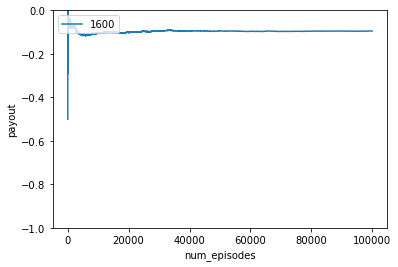

In [98]:
total_payout = 0 # to store total payout over 'num_rounds'
average_payouts1 = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
env.reset() 
num_samples = 100
for epoch in tqdm(range(num_samples)):
    current_round = 1
    round_payout = 0
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while current_round <= num_rounds:
        state = transfer_card_input(env.player, env.dealer)
        # observation = transfer_card_input(env.player, env.dealer) 
        action = DQ_agent.choose(state)
        # action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        next_state = transfer_card_input(env.player, env.dealer)
        DQ_agent.remember(state, action, next_state, payout)
        # DQ_agent.learn()

        if is_done:
            total_payout += payout
            round_payout += payout
            env.reset() # Environment deals new cards to player and dealer
            current_round += 1
            average_payouts1.append(total_payout/(epoch*num_rounds + current_round))
    print("payout for this epoch is {}".format(round_payout))


plt.plot(average_payouts1)
print ("Average payout after {} epoch after training is {}".format(epoch, total_payout/ num_samples))


# Plot payout per 1000 episodes for each value of 'num_episodes_to_train' in the same graph
plt.xlabel('num_episodes')
plt.ylabel('payout')
# plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.ylim(-1,0) # To zoom into this region
plt.show()
env.close()

#### Save the best model 

In [67]:
torch.save(DQ_agent.state_dict(), "-89.p")

In [74]:
DQ_agent.load_state_dict(torch.load("-89.p"))

#### The payout given by combination of all good results

#### TODO: Model comparsion for all of the model

It seems hard for all of four models to play with the same cards because of the environment settings.

In [ ]:
total_payout = 0 # to store total payout over 'num_rounds'
average_payouts1 = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
env.reset() 
num_samples = 100
for epoch in tqdm(range(num_samples)):
    current_round = 1
    round_payout = 0
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while current_round <= num_rounds:
        
        state = transfer_card_input(env.player, env.dealer)
        # random pick agent choose action
        random_action = env.action_space.sample
        obs, payout, is_done, _ = env.step(random_action)
        
        # rule base method choose action
        player_sum, dealer_up_card, is_done = (env._get_obs())
        rb_action = normal_strategy(player_sum, dealer_up_card) 
        
        # deep q learning agent choose action 
        dq_action = DQ_agent.choose(state)
        
        # q learning agent choose action
        q_action = agent.choose_action(observation)
        
        
        
        next_observation, payout, is_done, _ = env.step(action)
        # next_state = transfer_card_input(env.player, env.dealer)
        # DQ_agent.remember(state, action, next_state, payout)
        # DQ_agent.learn()

        if is_done:
            total_payout += payout
            round_payout += payout
            env.reset() # Environment deals new cards to player and dealer
            current_round += 1
            average_payouts1.append(total_payout/(epoch*num_rounds + current_round))
    print("payout for this epoch is {}".format(round_payout))


plt.plot(average_payouts1)
print ("Average payout after {} epoch after training is {}".format(epoch, total_payout/ num_samples))


# Plot payout per 1000 episodes for each value of 'num_episodes_to_train' in the same graph
plt.xlabel('num_episodes')
plt.ylabel('payout')
plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.ylim(-1,0) # To zoom into this region
plt.show()
env.close()

### Comparison with human performance

#### Load best model from deep q-learning

In [144]:
DQ_agent = NetworkAgent(n_inputs=16, n_outputs=2, gamma=0.75)

In [145]:
DQ_agent.load_state_dict(torch.load("-89.p"))

In [159]:
env.reset()
dq_test_payout = 0
current_round = 0
while current_round <= 10:
    state = transfer_card_input(env.player, env.dealer)
    action = DQ_agent.choose(state)
    next_observation, payout, is_done, _ = env.step(action)
    if is_done:
        dq_test_payout += payout
        current_round += 1
        print("The final cards for round {0} is player {1}, dealer {2}".format(current_round, 
                                                                               env.player, 
                                                                               env.dealer))
        print("The reward for this round is {}".format(payout))
        print("")
        env.reset()
print("The total results for 10 round of simulations is {}".format(dq_test_payout))

The final cards for round 1 is player [10, 1], dealer [10, 8]
The reward for this round is 1.0

The final cards for round 2 is player [8, 10], dealer [5, 3, 10]
The reward for this round is 0.0

The final cards for round 3 is player [7, 1, 8], dealer [10, 6, 10]
The reward for this round is 1.0

The final cards for round 4 is player [8, 6, 2], dealer [7, 3, 10]
The reward for this round is -1.0

The final cards for round 5 is player [10, 10], dealer [3, 10, 10]
The reward for this round is 1.0

The final cards for round 6 is player [1, 8], dealer [10, 5, 6]
The reward for this round is -1.0

The final cards for round 7 is player [5, 7, 9], dealer [10, 7]
The reward for this round is 1.0

The final cards for round 8 is player [3, 6, 9], dealer [9, 10]
The reward for this round is -1.0

The final cards for round 9 is player [10, 10], dealer [10, 10]
The reward for this round is 0.0

The final cards for round 10 is player [2, 10, 10], dealer [7, 10]
The reward for this round is -1

The fi

### Human tester 1 

### Human tester2

In [7]:
from gym import wrappers
env = gym.make('Blackjack-v0')